REFERENCE PAPERS

branch mlp : https://proceedings.mlr.press/v162/peng22a.html?ref=https://githubhelp.com

sklearn : @article{scikit-learn,
  title={Scikit-learn: Machine Learning in Python},
  author={Pedregosa, F. and Varoquaux, G. and Gramfort, A. and Michel, V. and Thirion, B. and Grisel, O. and Blondel, M. and Prettenhofer, P. and Weiss, R. and Dubourg, V. and Vanderplas, J. and Passos, A. and Cournapeau, D. and Brucher, M. and Perrot, M. and Duchesnay, E.},
  journal={Journal of Machine Learning Research},
  volume={12},
  pages={2825--2830},
  year={2011}
}

adding common layer : https://proceedings.nips.cc/paper/2021/file/cba0a4ee5ccd02fda0fe3f9a3e7b89fe-Paper.pdf
                      https://arxiv.org/abs/2307.00592
                      https://arxiv.org/abs/2112.04453

XGBoost: https://dl.acm.org/doi/abs/10.1145/2939672.2939785

Random forests: https://link.springer.com/article/10.1023/a:1010933404324

residual blocks : https://ar5iv.org/html/2105.03404v2
                  https://arxiv.org/abs/2107.08391

L2 regularisation : https://www.researchgate.net/publication/215721451_Neural_Networks_For_Pattern_Recognition (DOI:10.1093/oso/9780198538493.001.0001)
                    https://dl.acm.org/doi/abs/10.1145/1015330.1015435


In [16]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [17]:
from load_data import process_steel_data

full_path = 'data/'
path = 'data/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
correlation_rate = 0.2
dvl_line = 1

df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [18]:
df['steel_family'].value_counts()

steel_family
IF      6069
HSLA    5672
CMn     3855
Name: count, dtype: int64

In [19]:
# labeling the features for each branch
features = [col for col in df.columns if col not in ['r_value', 'steel_family', 'steel_grade']]
features_dict = {
   'time': [col for col in features if 'time' in col.lower()], 
   'chemical': ['pct_al', 'pct_b', 'pct_c', 'pct_cr', 'pct_mn', 'pct_n', 'pct_nb', 'pct_si', 'pct_ti', 'pct_v', 'mfia_coil_frac_fer', 'mfia_et1_frac_fer', 'mfia_et2_frac_fer'],
   'model': ["rm", "ag", "a80", "n_value"]
}
features_dict['process'] = [col for col in features if col not in features_dict['time'] and col not in features_dict['chemical']]

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split first to avoid data leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [21]:
class MultiBranchSteelRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim, hidden_units=64, dropout_rate=0.2):
        super().__init__()
        # Track which branches are active
        self.has_chemical = chemical_dim > 0
        self.has_time = time_dim > 0
        self.has_process = process_dim > 0
        self.has_model = model_dim > 0
        
        # Count active branches
        self.active_branches = sum([self.has_chemical, self.has_time, self.has_process, self.has_model])
        
        # Adjust hidden units for each branch
        self.branch_hidden = min(hidden_units, max(16, hidden_units // 2))
        
        # Creating branch
        def create_branch(input_dim):
            return nn.Sequential(
                nn.Linear(input_dim, self.branch_hidden),
                nn.BatchNorm1d(self.branch_hidden),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Only create branches that have features
        if self.has_chemical:
            self.chemical_branch = create_branch(chemical_dim)
        if self.has_time:
            self.time_branch = create_branch(time_dim)
        if self.has_process:
            self.process_branch = create_branch(process_dim)
        if self.has_model:
            self.model_branch = create_branch(model_dim)
        
        # Combined input dimension based on active branches only
        combined_dim = self.branch_hidden * self.active_branches
        
        # Final layers after concatenation
        self.final_layers = nn.Sequential(
            nn.Linear(combined_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 1)
        )
    
    def forward(self, chemical, time, process, model):
        features = []
        # Only process branches that have features
        if self.has_chemical:
            if chemical.dim() == 1:
                chemical = chemical.unsqueeze(0)
            features.append(self.chemical_branch(chemical))
        
        if self.has_time:
            if time.dim() == 1:
                time = time.unsqueeze(0)
            features.append(self.time_branch(time))
        
        if self.has_process:
            if process.dim() == 1:
                process = process.unsqueeze(0)
            features.append(self.process_branch(process))
        
        if self.has_model:
            if model.dim() == 1:
                model = model.unsqueeze(0)
            features.append(self.model_branch(model))
        
        # Concatenate only active features
        combined = torch.cat(features, dim=1) if len(features) > 1 else features[0]
        return self.final_layers(combined)

In [22]:
class EnhancedMultiBranchRegressor(nn.Module):
    def __init__(self, chemical_dim, time_dim, process_dim, model_dim=None, hyperparameters=None):
        super().__init__()

        default_params = {
            'batch_size': 32,
            'hidden_units': 64,
            'dropout_rate': 0.2,
            'cross_branch_dropout': 0,
            'final_layer_units': [128, 64],
            'final_layer_dropout': [0, 0],
            'activation': nn.ReLU(),
            'normalization': 'layer',
            'l2_lambda': 0.001,
            'residual_blocks': 2  # Number of residual blocks per branch
        }
        # Merge default and provided hyperparameters
        self.hp = {**default_params, **(hyperparameters or {})}

        def get_normalization(units):
            """Select normalization layer based on configuration."""
            if self.hp['normalization'] == 'batch':
                return nn.BatchNorm1d(units)
            elif self.hp['normalization'] == 'layer':
                return nn.LayerNorm(units)
            else:
                return nn.Identity()

        def create_residual_block(input_dim):
            """Create a residual block with adaptive configuration."""
            return ResidualBlock(
                input_dim, 
                self.hp['hidden_units'], 
                activation=self.hp['activation'], 
                dropout_rate=self.hp['dropout_rate'],
                normalization_func=get_normalization
            )

        def create_residual_branch(input_dim):
            """Create a residual branch with multiple blocks."""
            if input_dim <= 0:
                return None
            
            blocks = []
            # Initial projection layer
            blocks.append(nn.Linear(input_dim, self.hp['hidden_units']))
            blocks.append(get_normalization(self.hp['hidden_units']))
            blocks.append(self.hp['activation'])

            # Add residual blocks
            for _ in range(self.hp['residual_blocks']):
                blocks.append(create_residual_block(self.hp['hidden_units']))
            
            return nn.Sequential(*blocks)

        # Residual Branches
        self.branches = nn.ModuleDict({
            'chemical': create_residual_branch(chemical_dim),
            'time': create_residual_branch(time_dim),
            'process': create_residual_branch(process_dim),
            'model': create_residual_branch(model_dim)
        })

        # Cross-branch interaction
        active_branches = sum(1 for branch in self.branches.values() if branch is not None)
        cross_input_dim = self.hp['hidden_units'] * active_branches

        # Cross-branch interaction with residual connection
        self.cross_branch_interaction = nn.Sequential(
            nn.Linear(cross_input_dim, cross_input_dim // 2),
            self.hp['activation'],
            nn.Dropout(self.hp['cross_branch_dropout'])
        )

        # Dynamic final layers based on hyperparameters
        final_layers = []
        prev_units = cross_input_dim // 2
        for units, dropout_rate in zip(self.hp['final_layer_units'], self.hp['final_layer_dropout']):
            final_layers.extend([
                nn.Linear(prev_units, units),
                get_normalization(units),
                self.hp['activation'],
                nn.Dropout(dropout_rate)
            ])
            prev_units = units
        final_layers.append(nn.Linear(prev_units, 1))
        self.final_layers = nn.Sequential(*final_layers)

    def forward(self, chemical, time, process, model=None):
        processed_branches = []
        branch_inputs_and_names = [
            ('chemical', chemical, self.branches['chemical']),
            ('time', time, self.branches['time']),
            ('process', process, self.branches['process']),
            ('model', model, self.branches['model'])
        ]
        
        for name, input_tensor, branch in branch_inputs_and_names:
            if branch is not None and input_tensor is not None:
                processed_branches.append(branch(input_tensor))
        
        # Cross-branch interaction
        if len(processed_branches) > 1:
            cross_branch_features = torch.cat(processed_branches, dim=1)
            interaction_features = self.cross_branch_interaction(cross_branch_features)
        else:
            interaction_features = processed_branches[0]
        
        return self.final_layers(interaction_features)


# The ResidualBlock class remains unchanged
class ResidualBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, activation=nn.ReLU(), 
                 dropout_rate=0.2, normalization_func=None):
        super().__init__()
        
        # Use provided normalization function or default to Identity
        norm_func = normalization_func(hidden_dim) if normalization_func else nn.Identity()
        
        # Residual block with two linear layers
        self.block = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            norm_func,
            activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            norm_func
        )
        
        # Shortcut connection
        if input_dim != hidden_dim:
            self.shortcut = nn.Linear(input_dim, hidden_dim)
        else:
            self.shortcut = nn.Identity()
        
        # Final activation
        self.activation = activation

    def forward(self, x):
        # Residual connection
        residual = self.shortcut(x)
        out = self.block(x)
        
        # Combine residual and transformed features
        combined = residual + out
        return self.activation(combined)

In [23]:
def train_family_models_enhanced(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = EnhancedMultiBranchRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hyperparameters=hyperparameters  # Pass the entire hyperparameters dictionary
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            mae = mean_absolute_error(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2,
                'mae': mae
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [24]:
def train_family_models_regular(df, features_dict, num_epochs, hyperparameters, use_l2=False):
    family_models = {}
    evaluation_results = {}
    batch_size = hyperparameters['batch_size']

    for family in df['steel_family'].unique():
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)

        # Initialize feature arrays and dimensions
        feature_arrays = {}
        feature_dims = {}

        # Process each feature category
        for category in ['chemical', 'time', 'process', 'model']:
            available_features = [col for col in features_dict[category] 
                                if col in family_data.columns]

            if available_features:
                # Scale each feature category independently
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
                feature_dims[category] = len(available_features)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))  # Empty array
                feature_dims[category] = 0

        # Prepare targets
        targets = family_data['r_value'].values

        # Split data
        split_data = train_test_split(
            feature_arrays['chemical'],
            feature_arrays['time'],
            feature_arrays['process'],
            feature_arrays['model'],
            targets,
            test_size=0.2,
            random_state=42
        )

        (X_train_chem, X_test_chem, X_train_time, X_test_time, 
         X_train_proc, X_test_proc, X_train_model, X_test_model, 
         y_train, y_test) = split_data

        # Convert to tensors
        train_tensors = {
            'chemical': torch.FloatTensor(X_train_chem),
            'time': torch.FloatTensor(X_train_time),
            'process': torch.FloatTensor(X_train_proc),
            'model': torch.FloatTensor(X_train_model)
        }

        test_tensors = {
            'chemical': torch.FloatTensor(X_test_chem),
            'time': torch.FloatTensor(X_test_time),
            'process': torch.FloatTensor(X_test_proc),
            'model': torch.FloatTensor(X_test_model)
        }

        y_train_tensor = torch.FloatTensor(y_train)
        y_test_tensor = torch.FloatTensor(y_test)

        # Create DataLoader
        train_dataset = TensorDataset(
            train_tensors['chemical'],
            train_tensors['time'],
            train_tensors['process'],
            train_tensors['model'],
            y_train_tensor
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        # Initialize model
        model = MultiBranchSteelRegressor(
            chemical_dim=feature_dims['chemical'],
            time_dim=feature_dims['time'],
            process_dim=feature_dims['process'],
            model_dim=feature_dims['model'],
            hidden_units=hyperparameters['hidden_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )

        if use_l2:
            weight_decay = 0.001
        else:
            weight_decay = 0.0
        
        optimizer = torch.optim.AdamW(model.parameters(), weight_decay=weight_decay)
        criterion = nn.L1Loss()

        # Training loop
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for batch_chem, batch_time, batch_proc, batch_model, batch_targets in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_chem, batch_time, batch_proc, batch_model)
                loss = criterion(outputs, batch_targets.unsqueeze(1))
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            if (epoch + 1) % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        # Evaluation
        model.eval()
        with torch.no_grad():
            y_pred = model(
                test_tensors['chemical'],
                test_tensors['time'],
                test_tensors['process'],
                test_tensors['model']
            )
            test_loss = criterion(y_pred, y_test_tensor.unsqueeze(1)).item()
            y_pred_np = y_pred.numpy().flatten()
            r2 = r2_score(y_test, y_pred_np)
            mae = mean_absolute_error(y_test, y_pred_np)
            
            evaluation_results[family] = {
                'test_loss': test_loss,
                'r2_score': r2,
                'mae': mae
            }
            print(f"Evaluation for {family} - Test Loss: {test_loss:.4f}, R2: {r2:.4f}")

        family_models[family] = model

    return family_models, evaluation_results

In [25]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'learning_rate': [1e-3],
    'batch_size': [32, 64],
    'hidden_units': [64, 128],
    'dropout_rate': [0, 0.2],
    'cross_branch_dropout': [0, 0.2],
    'final_layer_units': [
        [128, 64],
        [256, 128],
    ],
    'final_layer_dropout': [
        [0, 0],
        [0.2, 0.2],
    ],
    'normalization': ['batch', 'layer']
}
grid = ParameterGrid(param_grid)

In [26]:
# from tqdm import tqdm

# num_epochs = 50

# best_results = {}
# best_params = None

# for params in tqdm(grid, desc="Grid Search Progress", leave=True):
#     print(f"\nEvaluating hyperparameters: {params}")
    
#     family_models, evaluation_results = train_family_models_enhanced(train_df, features_dict, num_epochs, params)
    
#     avg_r2 = np.mean([evaluation_results[family]['r2_score'] for family in evaluation_results])
    
#     if best_params is None or avg_r2 > best_results['avg_r2']:
#         best_results = {
#             'avg_r2': avg_r2,
#             'evaluation_results': evaluation_results
#         }
#         best_params = params

#     print(f"Average R2 Score: {avg_r2:.4f}")

# print(f"\nBest Hyperparameters: {best_params}")
# print(f"Best R2 Score: {best_results['avg_r2']:.4f}")


In [27]:
# best_results = {'avg_r2': 0.5774655195501973,
#  'evaluation_results': {'CMn': {'test_loss': 0.057762887328863144,
#    'r2_score': 0.543479086418242},
#   'HSLA': {'test_loss': 0.024983583018183708, 'r2_score': 0.718411446680632},
#   'IF': {'test_loss': 0.12141738831996918, 'r2_score': 0.47050602555171783}}}

In [28]:
best_params_grid = {'batch_size': 32,
 'cross_branch_dropout': 0,
 'dropout_rate': 0.2,
 'final_layer_dropout': [0, 0],
 'final_layer_units': [128, 64],
 'hidden_units': 64,
 'learning_rate': 0.001,
 'normalization': 'layer'}

In [29]:
best_params = {'batch_size': 32,
 'dropout_rate': 0.2,
 'hidden_units': 64,
 'learning_rate': 0.001,
 'l2_lambda': 0.001
}

In [30]:
family_models, eval_regular = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1965
Epoch [20/100], Loss: 0.1714
Epoch [30/100], Loss: 0.1711
Epoch [40/100], Loss: 0.1582
Epoch [50/100], Loss: 0.1554
Epoch [60/100], Loss: 0.1532
Epoch [70/100], Loss: 0.1490
Epoch [80/100], Loss: 0.1431
Epoch [90/100], Loss: 0.1448
Epoch [100/100], Loss: 0.1396
Evaluation for CMn - Test Loss: 0.1403, R2: 0.6699
Epoch [10/100], Loss: 0.2423
Epoch [20/100], Loss: 0.2259
Epoch [30/100], Loss: 0.2171
Epoch [40/100], Loss: 0.2103
Epoch [50/100], Loss: 0.2105
Epoch [60/100], Loss: 0.2038
Epoch [70/100], Loss: 0.2054
Epoch [80/100], Loss: 0.2009
Epoch [90/100], Loss: 0.1979
Epoch [100/100], Loss: 0.1997
Evaluation for IF - Test Loss: 0.2057, R2: 0.6441
Epoch [10/100], Loss: 0.1479
Epoch [20/100], Loss: 0.1342
Epoch [30/100], Loss: 0.1267
Epoch [40/100], Loss: 0.1189
Epoch [50/100], Loss: 0.1209
Epoch [60/100], Loss: 0.1146
Epoch [70/100], Loss: 0.1132
Epoch [80/100], Loss: 0.1126
Epoch [90/100], Loss: 0.1120
Epoch [100/100], Loss: 0.1116
Evaluation for HSLA - Test

In [31]:
def plot_actual_vs_predicted(df, family_models, features_dict):
    families = df['steel_family'].unique()
    for family in families:
        # Filter data for the current family
        family_data = df[df['steel_family'] == family].drop(['steel_family'], axis=1)
        
        # Prepare feature arrays
        feature_arrays = {}
        for category in features_dict.keys():
            available_features = [col for col in features_dict[category]
                                  if col in family_data.columns]
            if available_features:
                scaler = StandardScaler()
                feature_arrays[category] = scaler.fit_transform(family_data[available_features].values)
            else:
                feature_arrays[category] = np.zeros((len(family_data), 0))
        
        # Convert features to tensors
        input_tensors = {
            category: torch.FloatTensor(arr) for category, arr in feature_arrays.items()
        }
        
        # Make predictions
        with torch.no_grad():
            predicted = family_models[family](**input_tensors).numpy().flatten()
        
        # Get actual values
        actual = family_data['r_value'].values
        
        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        
        # Create a new figure for each family
        plt.figure(figsize=(10, 8))
        
        # Scatter plot
        plt.scatter(actual, predicted, alpha=0.5)
        
        # Linear regression line
        m, b = np.polyfit(actual, predicted, 1)
        plt.plot(actual, m*actual + b, color='red', linestyle='--', label='Regression Line')
        
        # Perfect prediction line
        plt.plot([actual.min(), actual.max()], 
                 [actual.min(), actual.max()], 
                 color='green', linestyle=':', label='Perfect Prediction')
        
        # Set plot limits with buffer
        buffer = 0.2
        x_min, x_max = actual.min() - (actual.max() - actual.min()) * buffer, actual.max() + (actual.max() - actual.min()) * buffer
        y_min, y_max = predicted.min() - (predicted.max() - predicted.min()) * buffer, predicted.max() + (predicted.max() - predicted.min()) * buffer
        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)
        
        # Labeling
        plt.xlabel('Actual R-value')
        plt.ylabel('Predicted R-value')
        plt.title(f'{family} Family\nR² = {r2:.4f}, MAE = {mae:.4f}')
        plt.axis('equal')
        plt.legend()
        
        # Adjust layout and show plot
        plt.tight_layout()
        plt.show()

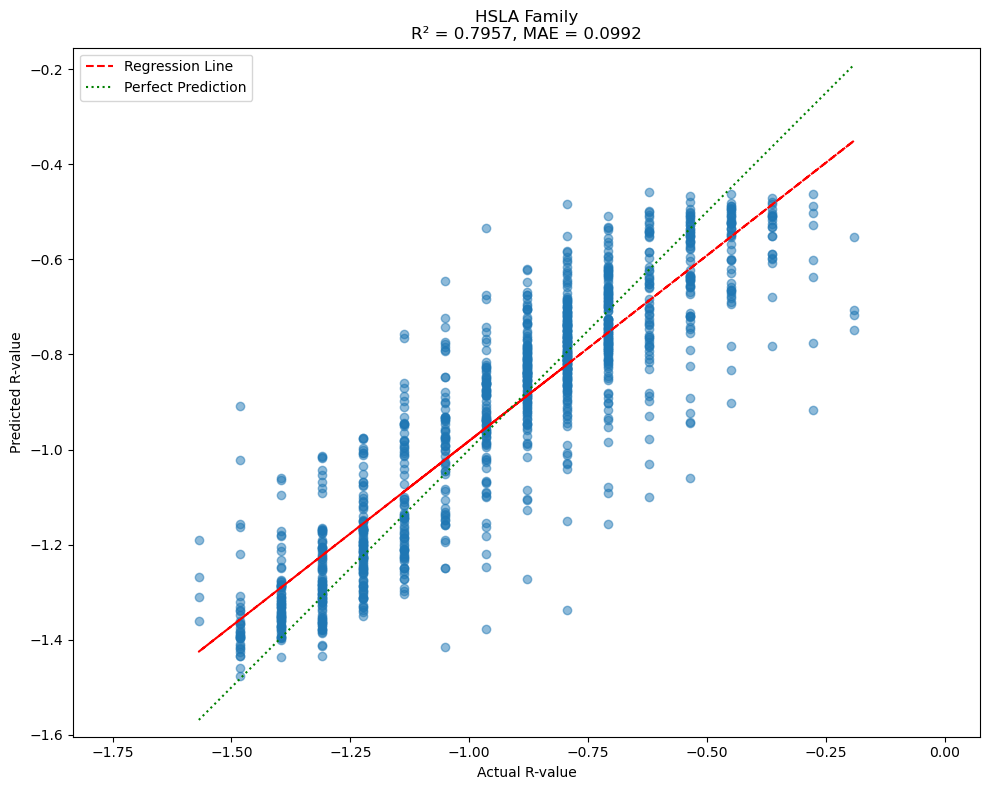

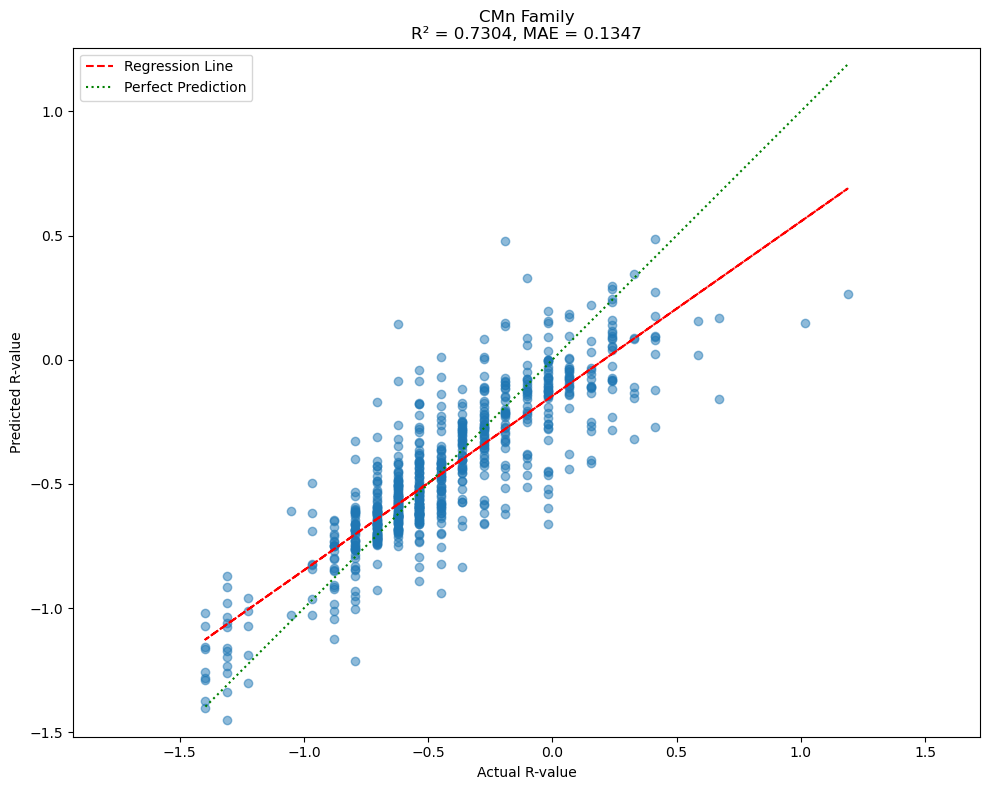

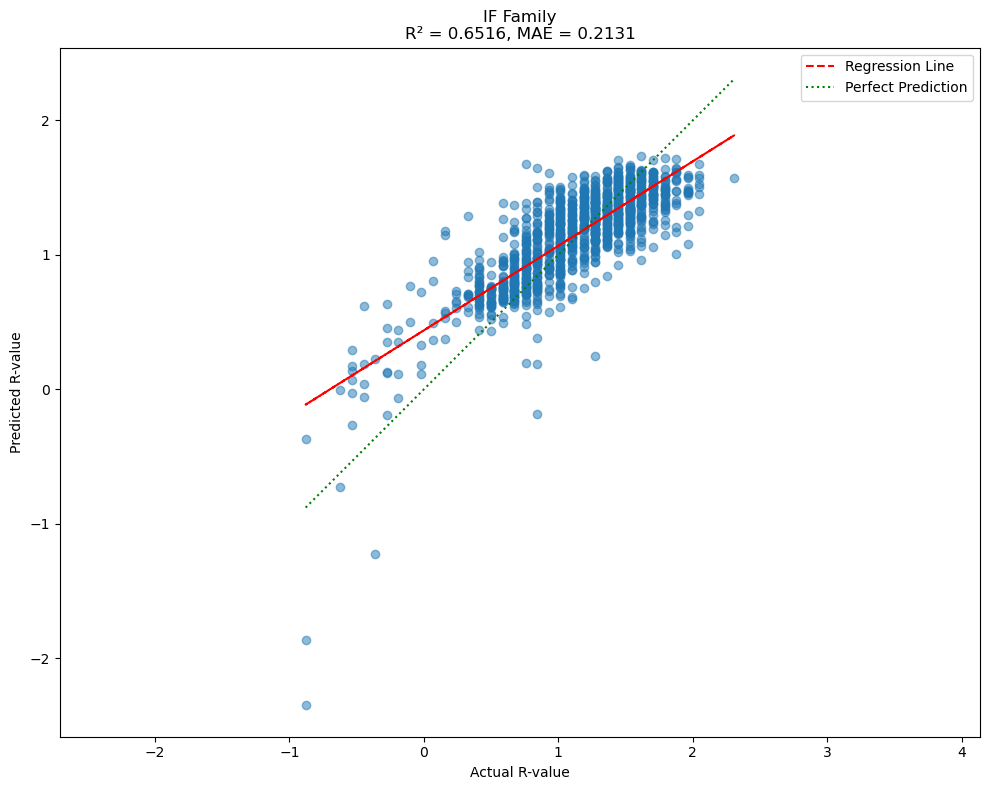

In [32]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [33]:
family_models_enhanced, eval_enhanced = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params_grid)

Epoch [10/100], Loss: 0.1431
Epoch [20/100], Loss: 0.1202
Epoch [30/100], Loss: 0.1083
Epoch [40/100], Loss: 0.1042
Epoch [50/100], Loss: 0.0903
Epoch [60/100], Loss: 0.0831
Epoch [70/100], Loss: 0.0773
Epoch [80/100], Loss: 0.0737
Epoch [90/100], Loss: 0.0634
Epoch [100/100], Loss: 0.0603
Evaluation for CMn - Test Loss: 0.1504, R2: 0.5857
Epoch [10/100], Loss: 0.2027
Epoch [20/100], Loss: 0.1858
Epoch [30/100], Loss: 0.1730
Epoch [40/100], Loss: 0.1616
Epoch [50/100], Loss: 0.1536
Epoch [60/100], Loss: 0.1433
Epoch [70/100], Loss: 0.1294
Epoch [80/100], Loss: 0.1232
Epoch [90/100], Loss: 0.1098
Epoch [100/100], Loss: 0.1004
Evaluation for IF - Test Loss: 0.2223, R2: 0.5768
Epoch [10/100], Loss: 0.1015
Epoch [20/100], Loss: 0.0909
Epoch [30/100], Loss: 0.0846
Epoch [40/100], Loss: 0.0789
Epoch [50/100], Loss: 0.0753
Epoch [60/100], Loss: 0.0680
Epoch [70/100], Loss: 0.0652
Epoch [80/100], Loss: 0.0598
Epoch [90/100], Loss: 0.0566
Epoch [100/100], Loss: 0.0520
Evaluation for HSLA - Test

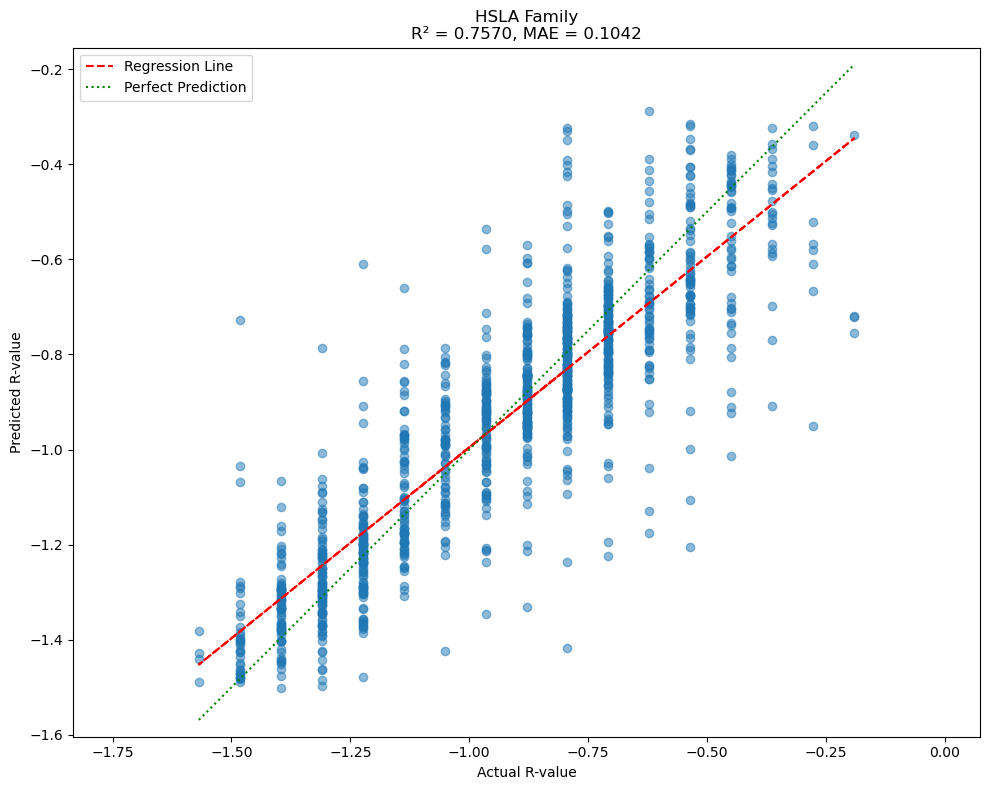

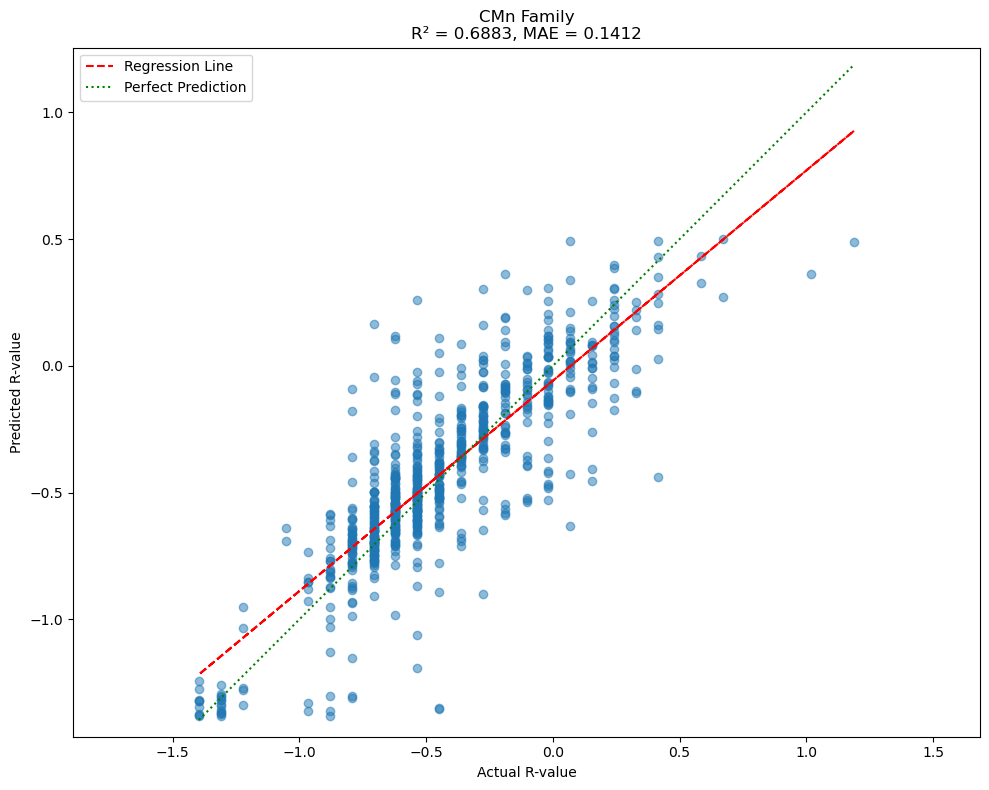

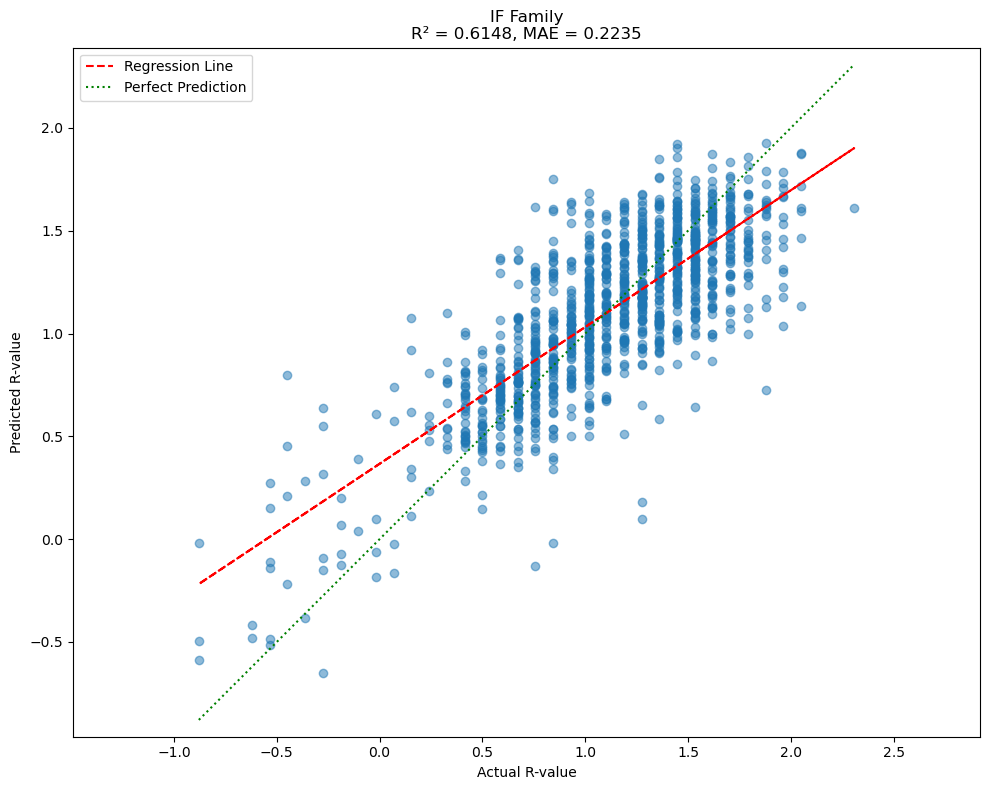

In [34]:
plot_actual_vs_predicted(test_scaled_df, family_models_enhanced, features_dict)

In [35]:
df = process_steel_data(full_path, path, correlation_rate, dvl_line, model_output=False)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family', 'steel_grade'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

test_scaled = scaler.transform(test_df.drop(['steel_family', 'steel_grade'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family', 'steel_grade'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

Dropped 24 columns


/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [36]:
family_models, eval_regular_no_model = train_family_models_regular(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1990
Epoch [20/100], Loss: 0.1861
Epoch [30/100], Loss: 0.1803
Epoch [40/100], Loss: 0.1747
Epoch [50/100], Loss: 0.1695
Epoch [60/100], Loss: 0.1673
Epoch [70/100], Loss: 0.1704
Epoch [80/100], Loss: 0.1642
Epoch [90/100], Loss: 0.1628
Epoch [100/100], Loss: 0.1621
Evaluation for CMn - Test Loss: 0.1651, R2: 0.5706
Epoch [10/100], Loss: 0.2663
Epoch [20/100], Loss: 0.2549
Epoch [30/100], Loss: 0.2450
Epoch [40/100], Loss: 0.2410
Epoch [50/100], Loss: 0.2359
Epoch [60/100], Loss: 0.2341
Epoch [70/100], Loss: 0.2310
Epoch [80/100], Loss: 0.2280
Epoch [90/100], Loss: 0.2284
Epoch [100/100], Loss: 0.2282
Evaluation for IF - Test Loss: 0.2462, R2: 0.4857
Epoch [10/100], Loss: 0.1643
Epoch [20/100], Loss: 0.1427
Epoch [30/100], Loss: 0.1377
Epoch [40/100], Loss: 0.1313
Epoch [50/100], Loss: 0.1296
Epoch [60/100], Loss: 0.1253
Epoch [70/100], Loss: 0.1262
Epoch [80/100], Loss: 0.1224
Epoch [90/100], Loss: 0.1210
Epoch [100/100], Loss: 0.1183
Evaluation for HSLA - Test

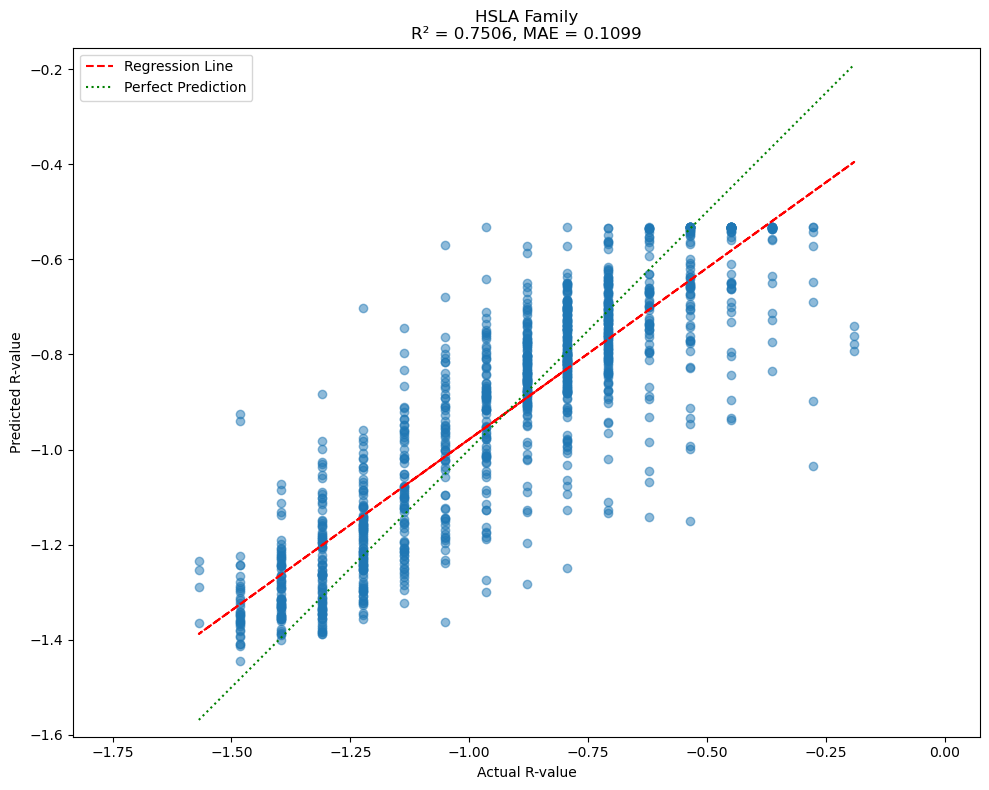

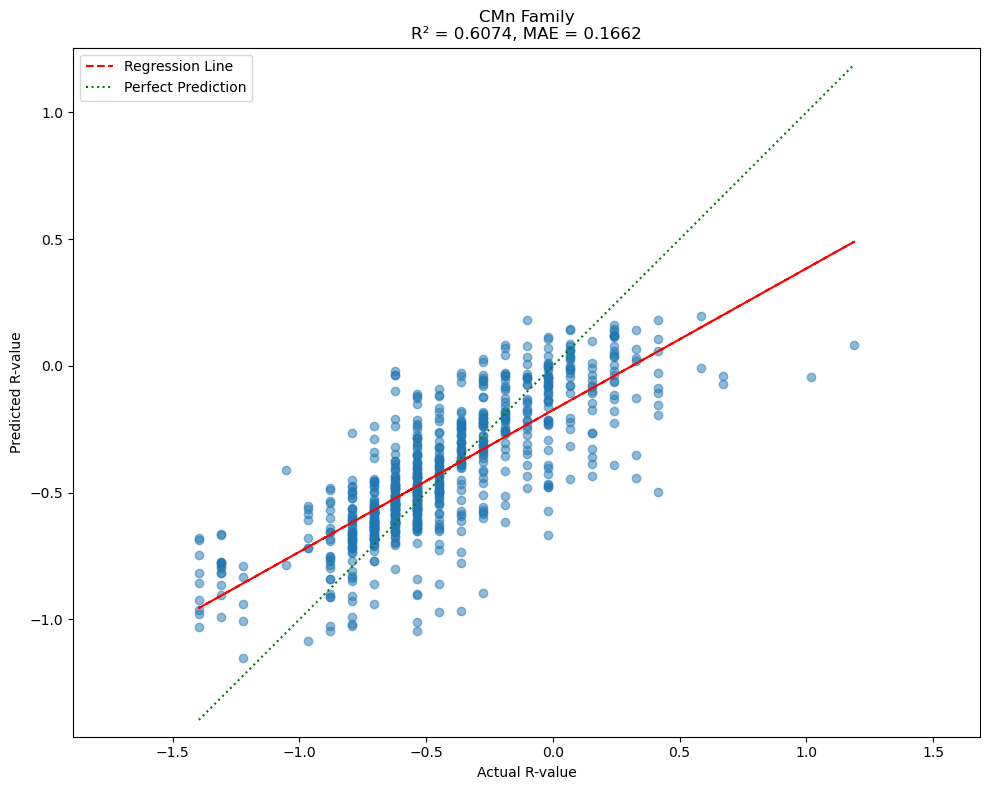

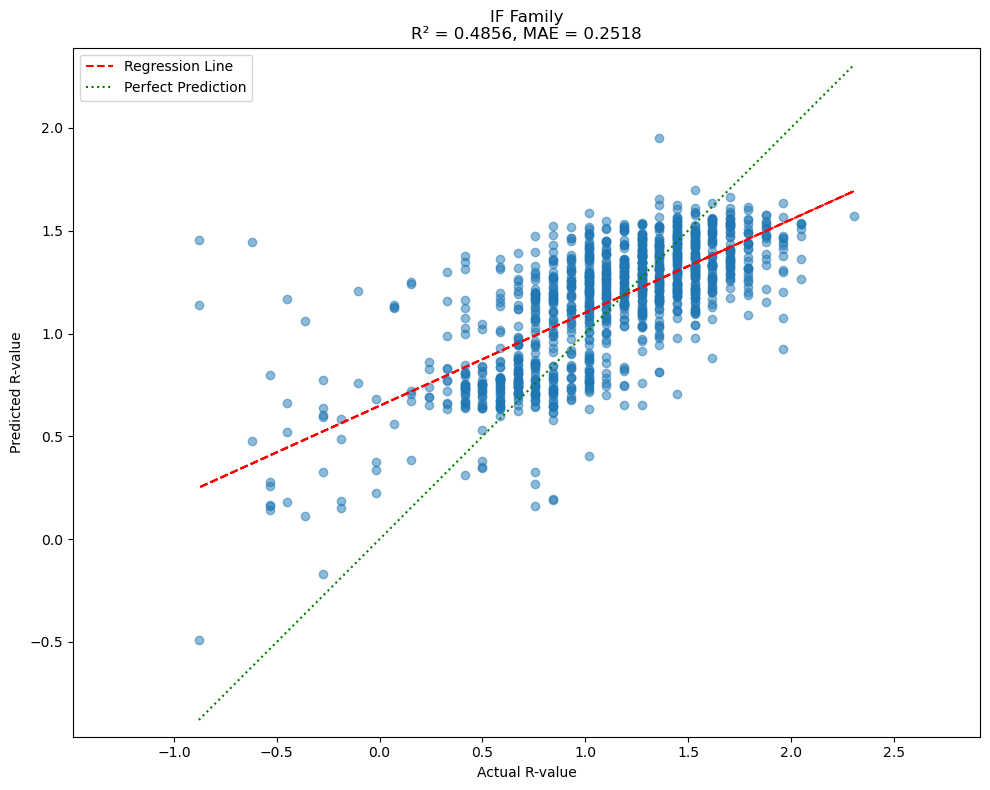

In [37]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [38]:
family_models, eval_enhanced_no_model = train_family_models_enhanced(train_scaled_df, features_dict, 100, best_params, use_l2=True)

Epoch [10/100], Loss: 0.1597
Epoch [20/100], Loss: 0.1439
Epoch [30/100], Loss: 0.1347
Epoch [40/100], Loss: 0.1208
Epoch [50/100], Loss: 0.1146
Epoch [60/100], Loss: 0.1027
Epoch [70/100], Loss: 0.0973
Epoch [80/100], Loss: 0.0909
Epoch [90/100], Loss: 0.0848
Epoch [100/100], Loss: 0.0800
Evaluation for CMn - Test Loss: 0.1772, R2: 0.4717
Epoch [10/100], Loss: 0.2309
Epoch [20/100], Loss: 0.2162
Epoch [30/100], Loss: 0.2041
Epoch [40/100], Loss: 0.1952
Epoch [50/100], Loss: 0.1815
Epoch [60/100], Loss: 0.1691
Epoch [70/100], Loss: 0.1610
Epoch [80/100], Loss: 0.1504
Epoch [90/100], Loss: 0.1400
Epoch [100/100], Loss: 0.1307
Evaluation for IF - Test Loss: 0.2636, R2: 0.3931
Epoch [10/100], Loss: 0.1101
Epoch [20/100], Loss: 0.1004
Epoch [30/100], Loss: 0.0964
Epoch [40/100], Loss: 0.0881
Epoch [50/100], Loss: 0.0815
Epoch [60/100], Loss: 0.0799
Epoch [70/100], Loss: 0.0731
Epoch [80/100], Loss: 0.0679
Epoch [90/100], Loss: 0.0626
Epoch [100/100], Loss: 0.0615
Evaluation for HSLA - Test

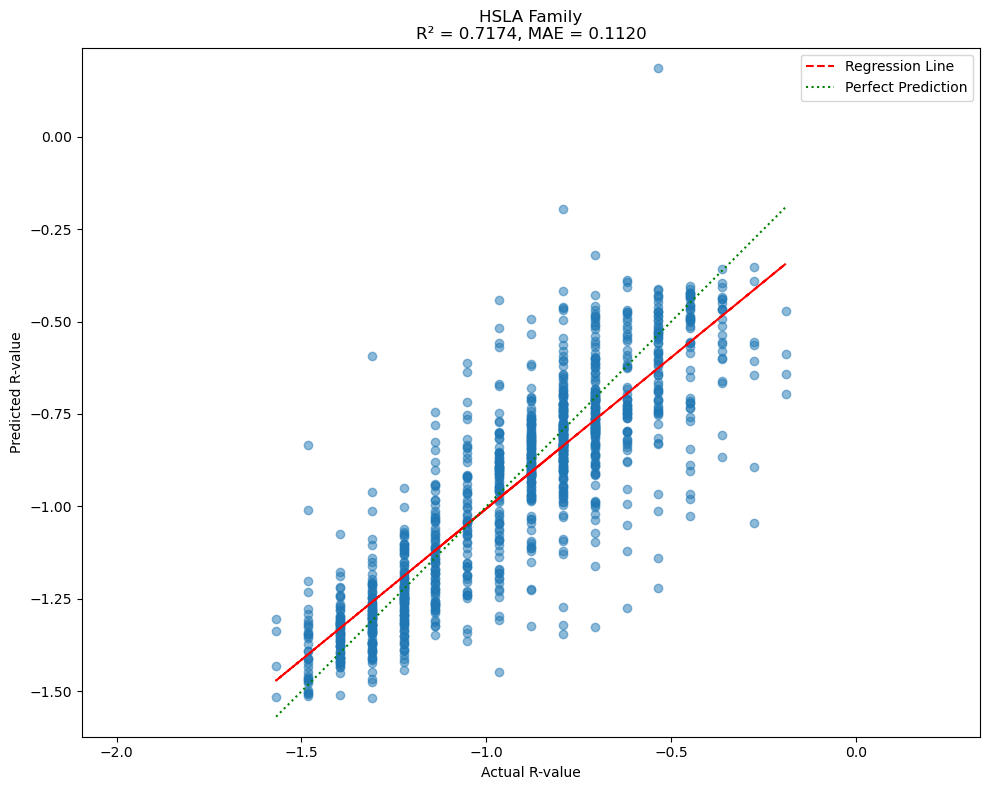

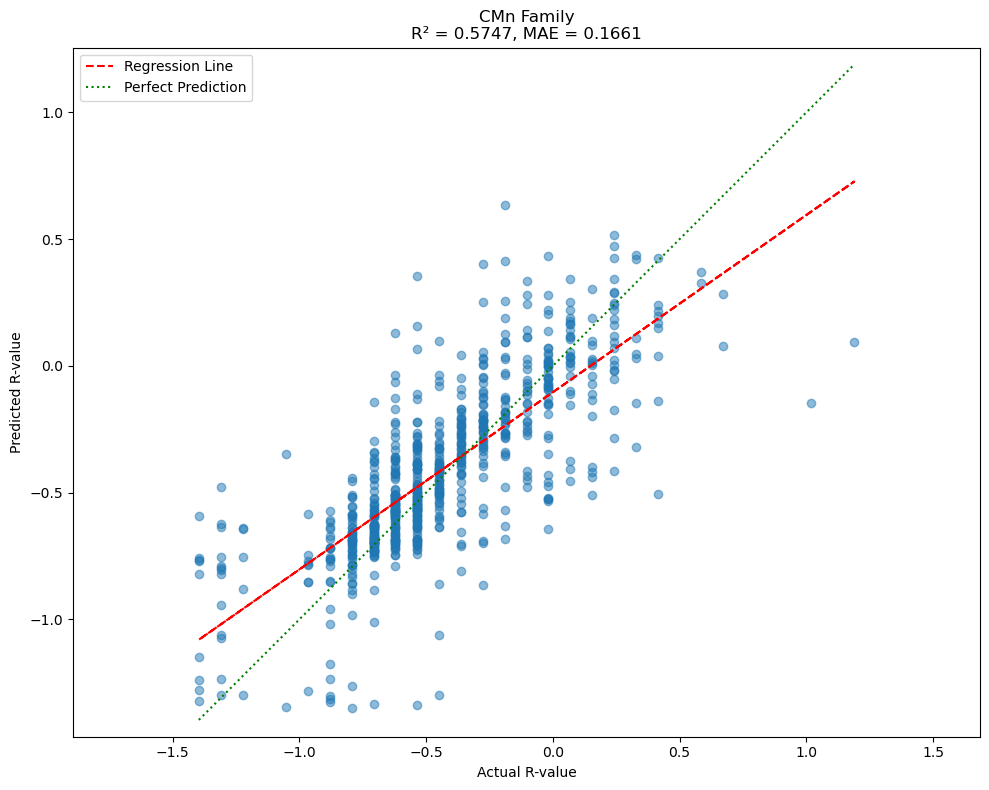

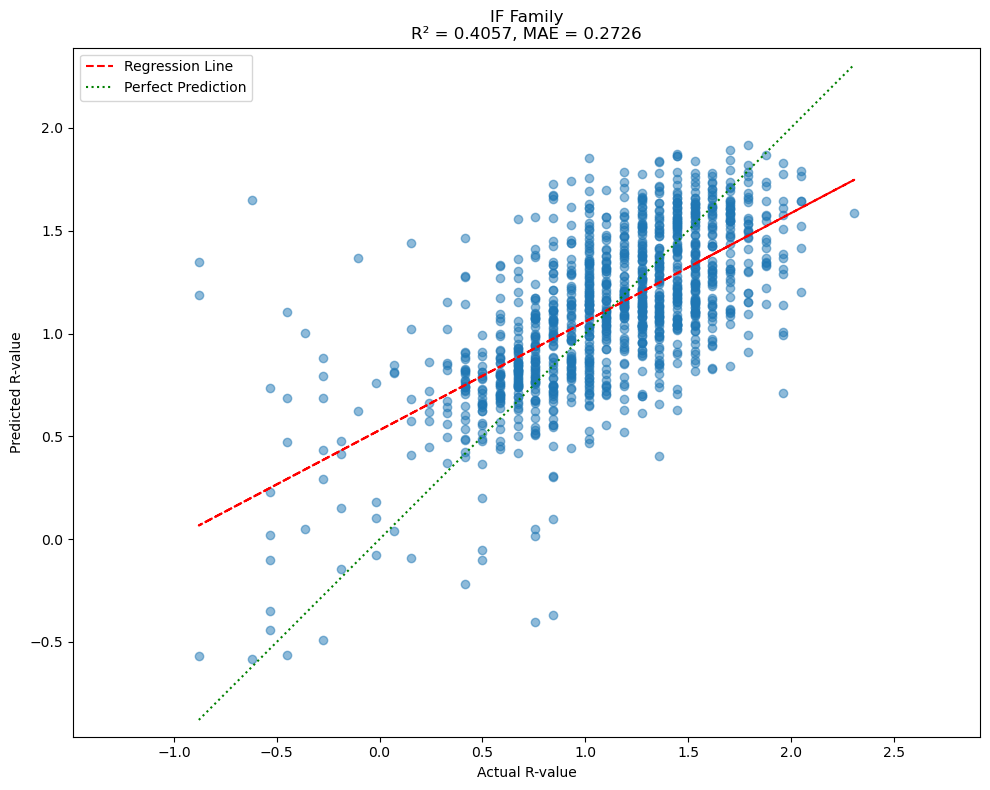

In [39]:
plot_actual_vs_predicted(test_scaled_df, family_models, features_dict)

In [40]:
eval_regular_no_model

{'CMn': {'test_loss': 0.1650773584842682,
  'r2_score': 0.5705772963097027,
  'mae': 0.16507736165394668},
 'IF': {'test_loss': 0.24622997641563416,
  'r2_score': 0.48571800417997957,
  'mae': 0.24622996408547002},
 'HSLA': {'test_loss': 0.10825292021036148,
  'r2_score': 0.7318188371638114,
  'mae': 0.10825292170411253}}

In [55]:
all_models = {'regular': eval_regular, 'regular_no_model_output': eval_regular_no_model, 'enhanced': eval_enhanced, 'enhanced_no_model_output': eval_enhanced_no_model}
data = []
for model, metrics in all_models.items():
    for category, values in metrics.items():
        data.append({
            'Model': model,
            'Steel family': category,
            'r2_score': values['r2_score'],
            'Mean Absolute Error': values['mae']
        })
df = pd.DataFrame(data)
df

,Model,Steel family,r2_score,Mean Absolute Error
0,regular,CMn,0.669868,0.140316
1,regular,IF,0.644101,0.205693
2,regular,HSLA,0.786370,0.095233
3,regular_no_model_output,CMn,0.570577,0.165077
4,regular_no_model_output,IF,0.485718,0.246230
5,regular_no_model_output,HSLA,0.731819,0.108253
6,enhanced,CMn,0.585670,0.150405
7,enhanced,IF,0.576840,0.222276
8,enhanced,HSLA,0.737967,0.104644
9,enhanced_no_model_output,CMn,0.471692,0.177207


In [57]:
df.to_csv('results_mlp.csv', index=False) 

In [58]:
csv_files = [f for f in os.listdir() if f.endswith('.csv')]
dataframes = []

for file in csv_files:
    df = pd.read_csv(file)
    dataframes.append(df)

merged_df = pd.concat(dataframes, ignore_index=True)
merged_df.to_csv('merged_results.csv', index=False)

In [59]:
merged_df

,Model,Steel family,r2_score,Mean Absolute Error
0,regular,CMn,0.669868,0.140316
1,regular,IF,0.644101,0.205693
2,regular,HSLA,0.786370,0.095233
3,regular_no_model_output,CMn,0.570577,0.165077
4,regular_no_model_output,IF,0.485718,0.246230
5,regular_no_model_output,HSLA,0.731819,0.108253
6,enhanced,CMn,0.585670,0.150405
7,enhanced,IF,0.576840,0.222276
8,enhanced,HSLA,0.737967,0.104644
9,enhanced_no_model_output,CMn,0.471692,0.177207
